# 1. Data Collection

-  The data consists concentration of pollutants - Carbon Monixide (CO),PM2.5 and Ozone for different California counries for the years 2010 to 2021. 
- The raw data contains the columns:
 - <b>Date</b> : The date the observation was taken.
 - <b>Source</b> : Source of the observation.
 - <b>Site ID</b> : Site ID for the particular site in the California county.
 - <b>POC</b> : This is the "Parameter Occurrence Code" used to distinguish different instruments that measure the same parameter at the same site.
 - <b>Daily Mean Pollutant Concentration</b> : Mean concentration for the pollutant for the date.
 - <b>UNITS</b> : Units of measurement for the pollutant concentration.
 - <b>DAILY_AQI_VALUE</b> : Air Quality Index value for the date.
 - <b>Site Name</b> : Site Name within the County.
 - <b>DAILY_OBS_COUNT</b> : The number of values that comprise the daily data set.
 - <b>PERCENT_COMPLETE</b> : The percentage of required observations (or scheduled days) made for the given assessment time period.
 - <b>AQS_PARAMETER_CODE</b> : The AQS code corresponding to the parameter measured by the monitor
 - <b>AQS_PARAMETER_DESC</b> : description assigned in AQS to the parameter measured by the monitor. Parameters may be pollutants or non-pollutants (e.g., wind speed).
 - <b>CBSA_CODE</b> : The code of the core based statistical area (metropolitan area)             where the monitoring site is located.
 - <b>CBSA_NAME</b>: The short version of the OMB-assigned title for the core-based statistical area (CBSA).
 - <b>STATE_CODE</b> : Code for the State in USA.
 - <b>STATE</b> : State Name
 - <b>COUNTY_CODE</b> : County code within the State.
 - <b>COUNTY</b> : County name.
 - <b>SITE_LATITUDE</b> : Latitude for the site.
 - <b>SITE_LONGITUDE</b> :Longiture fir the site.


- All the data pertaining to the pollutants has been stored in a public github repository : https://github.com/wadhawanabhishek/CrowdDoing


- Each pollutant information has been stored in a separate folder within the repository as follows:-

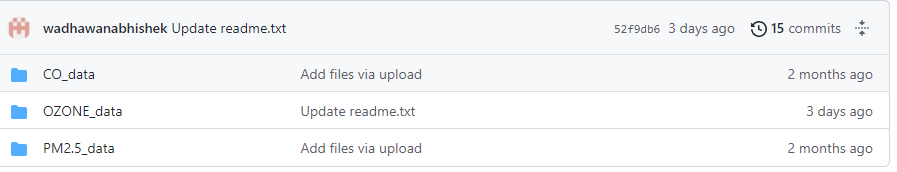

# 2. Data Transformation

The data stored in the github repository is transformed for  further analysis.
 - Data is transformed from a daily level of pollutant concentration to a monthly level.
 - Along with pollutant concentration, the AQI levels are also calculated
 - Only the data corresponding to years fed to function is transformed an further analysed. 

In [32]:
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup
import plotly.express as px

# Currently we have data from 2010 - 2021

class Pollutant:
    #

    def __init__(self,pollutant:str,start_year:int,end_year:int):
        self.__pollutant = pollutant.upper()
        self.__start_year = start_year
        self.__end_year = end_year
        self.__master_list = []
        self.__pollutant_list = ["CO","PM2.5","OZONE"]
        self.__units = None
        
        assert self.__pollutant in self.__pollutant_list ,"Not a valid Pollutant"
        assert isinstance(start_year,int),"Start Year is not Integer!"
        assert isinstance(end_year,int),"End Year is not Integer!"


    @property
    def pollutant(self):
        return self.__pollutant

    def __get_data(self):

        #

        try:
            #
            year_regex = re.compile(r'\d\d\d\d')
            github_url = 'https://github.com/wadhawanabhishek/CrowdDoing/tree/main/'+self.__pollutant+'_data'
            result = requests.get(github_url)
            soup = BeautifulSoup(result.text, 'html.parser')
            csvfiles = soup.find_all(title=re.compile("\.csv$"))
        except:
            #
            print("Resuouce not Found!")

        filename = [ ]
        for i in csvfiles:
            #
            filename.append(i.extract().get_text())

        years=[]
        for file in filename:
            year = year_regex.search(file)
            years.append(year.group())
        years =[int(i) for i in years]

        # 2011-2016  
        if (self.__start_year < min(years)) or (self.__start_year > max(years)):
            #
            print("Invalid Year Range. The Start Year Does not Exist")

        if (self.__end_year > max(years)) or (self.__end_year < self.__start_year) or (self.__end_year < min(years)):
            #
            print("Invalid Year Range. The End Year Does not Exist")

        new_lst = [i for i in range(self.__start_year,self.__end_year+1)]

        check =  all(item in years for item in new_lst)

        up_file=[]

        if check == True:
            #
            for file in filename:
                for yr in new_lst:
                    if str(yr) in file:
                        up_file.append(file)
        else: 
            raise Exception("The data for the given years not present")

        github_url = github_url.replace("github.com",'raw.githubusercontent.com')
        github_url = github_url.replace("tree/",'')

        appended_data =[]

        for f in up_file:
            url = github_url +'/'+ f
            data = pd.read_csv(url)
            appended_data.append(data)

        final_df = pd.concat(appended_data)
        self.__units = final_df['UNITS'].unique()[0]
        return final_df

    def __feature_extraction(self,data_df):
        
        df = data_df
        df = df.iloc[:, [0,17,2,4,6,15]]
        df = df[df['STATE']=='California']
        return df

    def __get_transformed_data(self,f_df):
        initial_df= f_df
        drop_cols = ['Site ID','STATE']
        for col in drop_cols:
            initial_df = initial_df.drop(col,axis = 1)
        initial_df = initial_df.groupby(['COUNTY','Date']).sum()
        initial_df=initial_df.reset_index(['Date','COUNTY'])
        initial_df['Date']= pd.to_datetime(initial_df['Date'],format='%m/%d/%Y')
        initial_df['Year']= pd.to_datetime(initial_df['Date']).dt.to_period('Y')
        initial_df['Month']= pd.to_datetime(initial_df['Date']).dt.to_period('M')
        initial_df = initial_df.drop("Date",axis = 1)
        cols = [initial_df.columns]
        final_df = initial_df.groupby(['COUNTY','Year','Month']).mean()
        final_df = final_df.reset_index(['COUNTY','Year','Month'])
        pollutant_col = "Monthly Avg "+ self.__pollutant+ " Concentration"
        final_df = final_df.rename(columns={final_df.columns[3]:pollutant_col,"DAILY_AQI_VALUE":"Monthly_Avg_AQI_VALUE"})
        final_df['Pollutant']= self.__pollutant
        final_df['Units'] = self.__units
        return final_df    

    def run(self):
        data_df = self.__get_data()
        feature_df = self.__feature_extraction(data_df)
        trans_df = self.__get_transformed_data(feature_df)
        return trans_df





In [33]:
df1 = Pollutant("co",2010,2021).run()
df2 = Pollutant("pm2.5",2010,2021).run()
df3 = Pollutant("ozone",2010,2021).run()

In [34]:
df1.head()

,COUNTY,Year,Month,Monthly Avg CO Concentration,Monthly_Avg_AQI_VALUE,Pollutant,Units
0,Alameda,2010,2010-01,2.645161,30.451613,CO,ppm
1,Alameda,2010,2010-02,2.071429,23.892857,CO,ppm
2,Alameda,2010,2010-03,1.754839,20.322581,CO,ppm
3,Alameda,2010,2010-04,1.316667,15.533333,CO,ppm
4,Alameda,2010,2010-05,0.993548,11.000000,CO,ppm


In [35]:
df2.head()

,COUNTY,Year,Month,Monthly Avg PM2.5 Concentration,Monthly_Avg_AQI_VALUE,Pollutant,Units
0,Alameda,2010,2010-01,62.574194,226.096774,PM2.5,ug/m3 LC
1,Alameda,2010,2010-02,41.082143,165.857143,PM2.5,ug/m3 LC
2,Alameda,2010,2010-03,35.087097,145.677419,PM2.5,ug/m3 LC
3,Alameda,2010,2010-04,31.866667,132.100000,PM2.5,ug/m3 LC
4,Alameda,2010,2010-05,29.545161,123.096774,PM2.5,ug/m3 LC


In [36]:
df3.head()

,COUNTY,Year,Month,Monthly Avg OZONE Concentration,Monthly_Avg_AQI_VALUE,Pollutant,Units
0,Alameda,2010,2010-01,0.075323,69.709677,OZONE,ppm
1,Alameda,2010,2010-02,0.106214,98.642857,OZONE,ppm
2,Alameda,2010,2010-03,0.140323,129.774194,OZONE,ppm
3,Alameda,2010,2010-04,0.147800,136.766667,OZONE,ppm
4,Alameda,2010,2010-05,0.136323,126.354839,OZONE,ppm


# 3. Concentration Trends for Different Counties Over the Years

- After the data is transformed to the desired level, the pollutant concentration and AQI values are plotted for different years for different counties.  
- This is done to analyse whether the pollutant concentrations follow a particluar pattern in different counties and to understand the trend of pollutant concentration in different counties within California.
- Further, The year in which the pollutant levels were maximum for most of the counties is analysed.
- Here the function takes two arguments - 
 1. The transformed data for the pollutant analysed
 2. conc / aqi : Whether the pollutant concentration needs to be plotted or the AQI levels.   

In [37]:
from plotly.subplots import make_subplots
from math import ceil
import plotly.graph_objects as go

class Plot_Map():
    
    def __init__(self,df,calc_type:str):
        self.df = df
        self.typ = calc_type.lower()
        self.__pollutant = None
        self.units = None
        
        assert self.typ in ['conc','aqi'], "Not a valid Calculation Type!"
        
    def _transform_data(self):
        
        self.__pollutant = self.df.Pollutant.unique().tolist()[0]
        units = self.df.Units.unique().tolist()[0]
        self.units = units
        trans_df = self.df.drop(['Month','Pollutant','Units'],axis=1)
        trans_df= trans_df.groupby(['COUNTY','Year']).mean()
        trans_df.reset_index(['COUNTY','Year'],inplace=True)
        trans_df['Year'] = trans_df.Year.apply(lambda x : str(x))
        cols = trans_df.columns.tolist()
        trans_df[cols[2]] = trans_df[cols[2]].round(2)
        trans_df[cols[3]] = trans_df[cols[3]].round(2)
        pollutant_col = "Yearly Avg "+ self.__pollutant+ " Concentration"+"("+units+")"
        aqi_col = "Yearly Avg "+ self.__pollutant+" AQI VALUE"
        trans_df = trans_df.rename(columns={trans_df.columns[2]:pollutant_col,trans_df.columns[3]:aqi_col})
        
        if self.typ == 'conc':
            trans_df.drop(trans_df.columns[3],axis=1,inplace=True)
        else:
            trans_df.drop(trans_df.columns[2],axis=1,inplace=True)
        
        return trans_df
    
    def __getmap(self,trans_df):
        
        trans_df = trans_df
        
        counties = trans_df.COUNTY.unique()
        # print(len(counties))
#         cols = df_x.columns
        rows = ceil(len(counties)/4)
        colus = 4
        fig = make_subplots(rows=rows, cols=colus,subplot_titles=counties)
        fig['layout'].update(height=3400, width=1800)
        fig['layout'].update(title = self.__pollutant+" Data Trend")
        r = 1
        c = 1


        for county in counties:
            cdf = trans_df[trans_df['COUNTY']==county]
#             col = cdf.columns
            fig.add_trace(go.Scatter(x=cdf['Year'], y=cdf.iloc[:,2] ,name=county),row=r, col=c)
            fig.update_xaxes(title_text = "Year")
            fig.update_yaxes(title_text = "Pollutant Concentration "+"("+self.units+")")

            c+=1
            if c > 4:
                r+=1
                c=1

        fig.show()        
#         return fig
    def __getmap_analysis(self,trans_df):
        trans_df = trans_df
        cols = trans_df.columns.tolist()
        dic= dict(trans_df.groupby("COUNTY")[cols[2]].max())
        lst =[]
        for county in dic.keys():
            val = trans_df[(trans_df["COUNTY"]==county) & (trans_df[cols[2]]==dic[county])]["Year"].values
            data = {"County": county,"Concentration":dic[county],"Year":val}
            lst.append(data)
    
        d = pd.DataFrame(lst)
        d= d.explode(['Year'])
        d_n = pd.DataFrame(d['Year'].value_counts()).reset_index()
        d_n= d_n.rename(columns = {"index":"Year","Year":"Count"})
        f = px.bar(d_n, x= "Year",y ="Count",text = "Count",text_auto=True)
        f['layout'].update(title = self.__pollutant+" Maximum Pollution Years")
        f.update_yaxes(title_text = "No. of Counties")
        f.show()

    def run(self):
        trans_data = self._transform_data()
        self.__getmap(trans_data)
        self.__getmap_analysis(trans_data)
        return trans_data

In [38]:
df4 = Plot_Map(df1,'conc').run()

In [39]:
df5 = Plot_Map(df2,'conc').run()

In [40]:
df6 = Plot_Map(df3,'conc').run()

# 4. Regression Analysis

- Regression Analysis (OLS method) is done to examine the relationship between Year and the pollutant concentration levels.
- The relation between different years and pollutant concentration is examined for different counties. For each county, the regression line slope value,R squared value, P-value and the regression line equation is calculated. Further, the significance of each relationship is checked by analysing the calculated P-value at a 95% confidence level.  

In [41]:
from sklearn import linear_model
import plotly.graph_objects as go
import warnings
from scipy import stats
import numpy as np
from plotly.subplots import make_subplots
warnings.filterwarnings("ignore")

class regression_analysis(Plot_Map):
    
    def __init__(self,df,calc_type):
        self.__pollutant = None
    
        super().__init__(df,calc_type)
        
    def __r_trans_df(self):
        
        df =  super()._transform_data()
        cols = df.columns
        self.__pollutant = cols[2].split()[2]
        df['Year'] = pd.to_numeric(df['Year'])
        return df
    
    def __reg_analysis(self,initial_df):
        
        df = initial_df
        cols = df.columns
        counties_list = df.COUNTY.unique().tolist()
        appended_data =[]
        
        for i,county in enumerate(counties_list):

            df2 = df[df['COUNTY']==county]

            ## Regression Analysis
            X = df2['Year'].values.tolist()
            y = df2[cols[2]].values.tolist()

            X_f = np.array(X, dtype=np.float32)
            y_f = np.array(y, dtype=np.float32)

            slope, intercept, r_value, p_value, std_err = stats.linregress(X_f,y_f)
            line = str(round(slope,4)) + ' * '+'Year '+ '+ ' + str(round(intercept,4))

            sig=lambda p_value: True if p_value <= 0.05 else False


            data = {'County':county,'Slope':slope,'R-Squared Value':r_value**2,'P-Value':p_value,
                    'P-Value less than 0.05?':sig(p_value),
                    'Line-Equation': line}

            data_df = pd.DataFrame(data,index = [i])
            appended_data.append(data_df)

            final_df = pd.concat(appended_data)
            
        self.__annotations = final_df['Line-Equation'].values.tolist()
        
        return final_df
    
    def __getmap(self,trans_df):
        
        map_df = trans_df
        map_df['Year'] = pd.to_numeric(map_df['Year'])
        cols = map_df.columns.tolist()
        
        fig = px.scatter(map_df, x="Year", y=cols[2], color="COUNTY",trendline='ols',trendline_color_override='red')

        fig.update_layout(
            title = self.__pollutant+" Data " + "Regression Analysis",
            updatemenus=[
                {
                    "buttons": [
                        {
                            "label": m,
                            "method": "update",
                            "args": [
                                {
                                    "visible": [
                                        True if m == "All" else t.name == m for t in fig.data
                                    ]
                    
                                }
                            ],
                        }
                        for m in ["All"] + map_df["COUNTY"].unique().tolist()
                    ]
                }
            ]
        )
        
        
        fig.show()
        
    def run(self):
        initial_df = self.__r_trans_df()
        final_df = self.__reg_analysis(initial_df)
#         f_df = final_df[['County','R-Squared_value']]
#         f_df = f_df.groupby(['County']).max()
#         f_df.reset_index(inplace=True)
        final_df['Pollutant']  = self.__pollutant
        self.__getmap(initial_df)
        return final_df
          

## 4.1 Regression Analysis for Carbon Monoxide Pollutant

In [42]:
df7 = regression_analysis(df1,'conc').run()
df7

,County,Slope,R-Squared Value,P-Value,P-Value less than 0.05?,Line-Equation,Pollutant
0,Alameda,0.181014,0.773692,1.622657e-04,True,0.181 * Year + -362.8829,CO
1,Butte,-0.005175,0.125143,2.592817e-01,False,-0.0052 * Year + 10.8099,CO
2,Contra Costa,0.026888,0.428582,2.088022e-02,True,0.0269 * Year + -52.9505,CO
3,Fresno,-0.074406,0.436578,1.932940e-02,True,-0.0744 * Year + 151.4761,CO
4,Humboldt,-0.021434,0.266949,8.544420e-02,False,-0.0214 * Year + 43.6885,CO
5,Imperial,-0.122622,0.789959,1.108163e-04,True,-0.1226 * Year + 248.0612,CO
6,Inyo,0.007143,0.474084,1.304062e-01,False,0.0071 * Year + -14.2862,CO
7,Kern,-0.024023,0.381131,4.300232e-02,True,-0.024 * Year + 48.9327,CO
8,Los Angeles,-0.321958,0.946043,1.151702e-07,True,-0.322 * Year + 656.4047,CO
9,Madera,-0.012000,0.450000,2.151700e-01,False,-0.012 * Year + 24.452,CO


## 4.2 Regression Analysis for PM2.5 Pollutant

In [43]:
df8 = regression_analysis(df2,'conc').run()
df8

,County,Slope,R-Squared Value,P-Value,P-Value less than 0.05?,Line-Equation,Pollutant
0,Alameda,2.086616,0.490191,0.016441,True,2.0866 * Year + -4165.0157,PM2.5
1,Alpine,1.158000,0.031944,0.734760,False,1.158 * Year + -2316.3115,PM2.5
2,Butte,0.642417,0.066192,0.445018,False,0.6424 * Year + -1262.7563,PM2.5
3,Calaveras,0.206515,0.109433,0.320385,False,0.2065 * Year + -407.4393,PM2.5
4,Colusa,0.544700,0.179519,0.194082,False,0.5447 * Year + -1081.8609,PM2.5
5,Contra Costa,1.036348,0.540636,0.009924,True,1.0363 * Year + -2072.5521,PM2.5
6,Del Norte,0.552797,0.575770,0.006777,True,0.5528 * Year + -1108.8905,PM2.5
7,El Dorado,0.518571,0.539057,0.010090,True,0.5186 * Year + -1039.8428,PM2.5
8,Fresno,3.834933,0.361976,0.050205,False,3.8349 * Year + -7643.3185,PM2.5
9,Glenn,0.219466,0.136211,0.264001,False,0.2195 * Year + -433.1729,PM2.5


## 4.3 Regression Analysis for Ozone Pollutant

In [44]:
df9 = regression_analysis(df3,'conc').run()
df9

,County,Slope,R-Squared Value,P-Value,P-Value less than 0.05?,Line-Equation,Pollutant
0,Alameda,0.005420,0.697124,0.000726,True,0.0054 * Year + -10.7857,OZONE
1,Amador,0.000000,0.000000,1.000000,False,0.0 * Year + 0.04,OZONE
2,Butte,-0.000420,0.094406,0.331313,False,-0.0004 * Year + 0.929,OZONE
3,Calaveras,0.000105,0.017165,0.684849,False,0.0001 * Year + -0.1706,OZONE
4,Colusa,-0.000315,0.154482,0.206256,False,-0.0003 * Year + 0.6734,OZONE
5,Contra Costa,0.003706,0.601327,0.003040,True,0.0037 * Year + -7.3434,OZONE
6,El Dorado,-0.000315,0.011560,0.739444,False,-0.0003 * Year + 0.7317,OZONE
7,Fresno,0.004965,0.553692,0.005518,True,0.005 * Year + -9.7087,OZONE
8,Glenn,0.000000,0.000000,1.000000,False,0.0 * Year + 0.04,OZONE
9,Humboldt,-0.000699,0.055208,0.462273,False,-0.0007 * Year + 1.4528,OZONE


# 5. Clustering The Counties 

- The Counties are now clustered based on their regression slope values
- The counties are then further divided on the bases of their clusters into different pollution trends - Low, Medium, Increasing, Heavily Increasing

In [45]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
class Clustering_data:
    
    def __init__(self,regression_df,clusters = 4):
        self.df = regression_df
        self.f_clusters = clusters
        
        
    def __cluster_number_analysis(self):
        self.df.sort_values('Slope',ignore_index=True,inplace=True)
        x1 = np.array(self.df.index.values)
        x2 = np.array(self.df['Slope'].values)
        X = np.array(list(zip(x1, x2))).reshape(len(x1), 2)
        X=np.nan_to_num(X)
        
#         distortions=[]
#         for i in range(1, 11):
#             km = KMeans(
#                 n_clusters=i, init='k-means++',
#                 n_init=10, max_iter=300,
#                 tol=1e-04, random_state=0
#             )
#             km.fit(X)
#             distortions.append(km.inertia_)

#         # plot
#         plt.plot(range(1, 11), distortions, marker='o')
#         plt.xlabel('Number of clusters')
#         plt.ylabel('Distortion')
#         plt.title("Determining the number of clusters")
#         plt.show()
        
        model = KMeans()
        visualizer = KElbowVisualizer(
            model, k=(2,10))

        visualizer.fit(X)        # Fit the data to the visualizer
        visualizer.poof() 
        
        return X
        
    def __assigning_clusters(self,X):
        km = KMeans(
        n_clusters=self.f_clusters, init='k-means++',
        n_init=10, max_iter=300, 
        tol=1e-04, random_state=0)
        y_km = km.fit_predict(X)
        
        self.df['Cluster']=y_km
        self.df['group'] = self.df['Cluster'].ne(self.df['Cluster'].shift()).cumsum()

        mapping = {1:'Low', 2:'Medium', 3:'Increasing',4:'Heavily Increasing'}

        self.df['Pollution Trend']= self.df['group'].apply(lambda x : mapping[x])
        self.df.drop('group',axis=1,inplace=True)
        
    def __plot_clusters(self):
        fig = px.scatter(self.df,x=self.df.index.values,y='Slope',color='Cluster',hover_name='County',labels = 
                         dict(x = "County Index", Slope = "Slope of Regression Line"))
        title = 'Clustering for '+ self.df['Pollutant'].unique()[0]+' data'
        fig.update_layout(title=title)
        fig.show()
        
    def run(self):
        X = self.__cluster_number_analysis()
        self.__assigning_clusters(X)
        self.__plot_clusters()
        final_df = self.df
        return final_df
        
    

## 5.1 Clustering Counties for Carbon Monoxide Pollutant

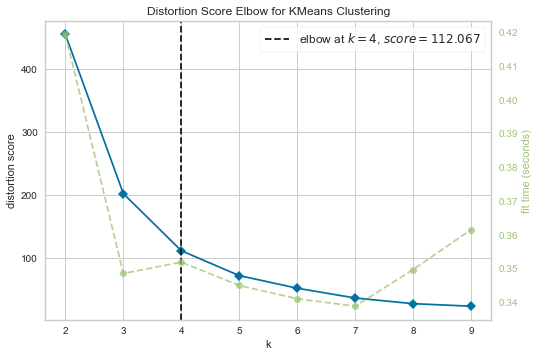

,County,Slope,R-Squared Value,P-Value,P-Value less than 0.05?,Line-Equation,Pollutant,Cluster,Pollution Trend
0,Los Angeles,-0.321958,0.946043,1.151702e-07,True,-0.322 * Year + 656.4047,CO,1,Low
1,Sacramento,-0.129720,0.810342,6.583694e-05,True,-0.1297 * Year + 262.9862,CO,1,Low
2,Imperial,-0.122622,0.789959,1.108163e-04,True,-0.1226 * Year + 248.0612,CO,1,Low
3,San Diego,-0.107867,0.438314,1.900591e-02,True,-0.1079 * Year + 218.9637,CO,1,Low
4,Santa Barbara,-0.090559,0.521985,7.952537e-03,True,-0.0906 * Year + 183.6775,CO,1,Low
5,Riverside,-0.090175,0.597405,3.201102e-03,True,-0.0902 * Year + 183.9449,CO,1,Low
6,Fresno,-0.074406,0.436578,1.932940e-02,True,-0.0744 * Year + 151.4761,CO,1,Low
7,Stanislaus,-0.051993,0.739006,3.371726e-04,True,-0.052 * Year + 105.3911,CO,3,Medium
8,Kern,-0.024023,0.381131,4.300232e-02,True,-0.024 * Year + 48.9327,CO,3,Medium
9,Humboldt,-0.021434,0.266949,8.544420e-02,False,-0.0214 * Year + 43.6885,CO,3,Medium


In [46]:
f1_df = Clustering_data(df7).run()
f1_df

### 5.1.1 Checking for Outliers

In [47]:
fig = px.box(f1_df, y="Slope",hover_name="County",title="CO Outliers")

fig.add_annotation(x=0.05, y=0.18, #Q1
            text="Alameda",
            font=dict(size=12),
            showarrow=False,
            )
fig.add_annotation(x=0.06, y=-0.32, #Q1
            text="Los Angeles",
            font=dict(size=12),
            showarrow=False,
            )

fig.show()

- For Carbon Monoxide, it is quite evident that the counties Alamaeda and Los Angeles are the outliers. Alamaeda had an increasing trend for pollutant concentration over the years while the county of Los Angeles had a decreasing trend for pollutant concentration over the years.

## 5.2 Clustering Counties for PM2.5 Pollutant

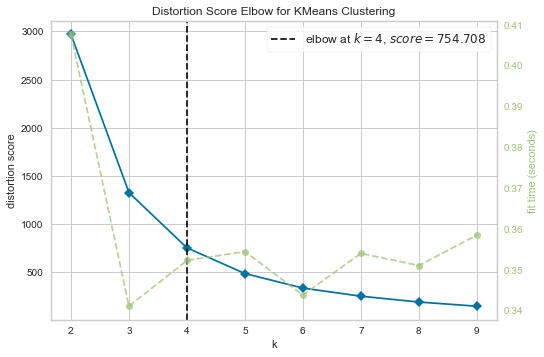

,County,Slope,R-Squared Value,P-Value,P-Value less than 0.05?,Line-Equation,Pollutant,Cluster,Pollution Trend
0,Riverside,-2.587156,0.292193,0.086014,False,-2.5872 * Year + 5346.4703,PM2.5,0,Low
1,Madera,-1.041656,0.559775,0.008090,True,-1.0417 * Year + 2117.1682,PM2.5,0,Low
2,Imperial,-0.913825,0.218636,0.146992,False,-0.9138 * Year + 1875.8925,PM2.5,0,Low
3,Humboldt,-0.437170,0.206439,0.160343,False,-0.4372 * Year + 891.8041,PM2.5,0,Low
4,Kern,-0.352737,0.014288,0.726295,False,-0.3527 * Year + 778.1667,PM2.5,0,Low
5,Marin,-0.298137,0.349405,0.055474,False,-0.2981 * Year + 611.202,PM2.5,0,Low
6,San Mateo,-0.210274,0.215366,0.150464,False,-0.2103 * Year + 432.1707,PM2.5,0,Low
7,Napa,-0.208031,0.117828,0.301373,False,-0.208 * Year + 429.1586,PM2.5,0,Low
8,Stanislaus,-0.188151,0.027286,0.627407,False,-0.1882 * Year + 406.6262,PM2.5,0,Low
9,San Francisco,-0.113725,0.101034,0.340817,False,-0.1137 * Year + 237.9259,PM2.5,0,Low


In [48]:
f2_df=Clustering_data(df8).run()
f2_df

### 5.2.1 Checking for Outliers

In [49]:
q1=f2_df["Slope"].quantile(0.25)

q3=f2_df["Slope"].quantile(0.75)

IQR=q3-q1

outliers = f2_df[((f2_df["Slope"]<(q1-1.5*IQR)) | (f2_df["Slope"]>(q3+1.5*IQR)))]
fig = px.box(f2_df, y="Slope",hover_name="County",title="PM2.5 Outliers")
outliers_annotations = outliers[["County","Slope"]].sort_values(by ="Slope",ascending=False)
outliers_lst = outliers_annotations.values.tolist()

for county, slope in outliers_lst:
    fig.add_annotation(x=0.05, y=slope, #Q1
            text=county,
            font=dict(size=10),
            showarrow=False,
            )
fig['layout'].update(height = 800,width =800)
fig.show()

- From the outlier analysis of PM2.5 pollutant concentrations, it is evident that the counties - Riverside and San Bernardino are the extreme outliers

## 5.3 Clustering Counties for Ozone Pollutant

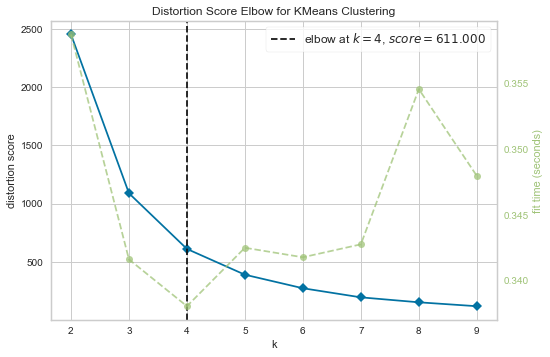

,County,Slope,R-Squared Value,P-Value,P-Value less than 0.05?,Line-Equation,Pollutant,Cluster,Pollution Trend
0,Santa Barbara,-0.016573,0.681139,0.000948,True,-0.0166 * Year + 33.8204,OZONE,1,Low
1,San Diego,-0.012308,0.770873,0.000173,True,-0.0123 * Year + 25.1911,OZONE,1,Low
2,Sacramento,-0.008007,0.584260,0.003791,True,-0.008 * Year + 16.3839,OZONE,1,Low
3,Mariposa,-0.004336,0.363258,0.038056,True,-0.0043 * Year + 8.8285,OZONE,1,Low
4,Nevada,-0.003636,0.756364,0.000237,True,-0.0036 * Year + 7.3941,OZONE,1,Low
5,Imperial,-0.002832,0.328504,0.051402,False,-0.0028 * Year + 5.8591,OZONE,1,Low
6,Orange,-0.002308,0.368487,0.036336,True,-0.0023 * Year + 4.7978,OZONE,1,Low
7,Santa Cruz,-0.002308,0.387223,0.030712,True,-0.0023 * Year + 4.6928,OZONE,1,Low
8,Ventura,-0.002063,0.593723,0.003358,True,-0.0021 * Year + 4.3853,OZONE,1,Low
9,Tulare,-0.001678,0.402797,0.026625,True,-0.0017 * Year + 3.5627,OZONE,1,Low


In [50]:
f3_df = Clustering_data(df9).run()
f3_df 

### 5.3.1 Checking for Outliers

In [51]:
q1=f3_df["Slope"].quantile(0.25)

q3=f3_df["Slope"].quantile(0.75)

IQR=q3-q1

outliers = f3_df[((f3_df["Slope"]<(q1-1.5*IQR)) | (f3_df["Slope"]>(q3+1.5*IQR)))]
fig = px.box(f3_df, y="Slope",hover_name="County",title = "Ozone Outliers")
outliers_annotations = outliers[["County","Slope"]].sort_values(by ="Slope",ascending=False)
outliers_lst = outliers_annotations.values.tolist()

for county, slope in outliers_lst:
    fig.add_annotation(x=0.06, y=slope, #Q1
            text=county,
            font=dict(size=10),
            showarrow=False,
            )
fig['layout'].update(height = 800,width =800)
fig.show()

- From the outlier analysis of Ozone pollutant concentrations, it is evident that the counties - Santa Barbara and Inyo are the extreme outliers

## 5.4 Analysing Pollution Trends 

- Analysing which Counties had the Pollution Trend as <b>Heavily Increasing</b> for all three pollutants:

In [52]:
##Getting counties with Heavily Increasing pollution trend for all 3 pollutants

co_counties_high = set(f1_df[f1_df['Pollution Trend']=='Heavily Increasing']['County'].values.tolist())
pm_counties_high = set(f2_df[f2_df['Pollution Trend']=='Heavily Increasing']['County'].values.tolist())
ozone_counties_high = set(f3_df[f3_df['Pollution Trend']=='Heavily Increasing']['County'].values.tolist())

common_counties_high = co_counties_high.intersection(pm_counties_high,ozone_counties_high)
common_counties_high

{'Alameda'}

- Analysing which Counties had the Pollution Trend as <b>Low</b> for all three pollutants:

In [53]:
##Getting counties with low pollution trend for all 3 pollutants

co_counties_low = set(f1_df[f1_df['Pollution Trend']=='Low']['County'].values.tolist())
pm_counties_low = set(f2_df[f2_df['Pollution Trend']=='Low']['County'].values.tolist())
ozone_counties_low = set(f3_df[f3_df['Pollution Trend']=='Low']['County'].values.tolist())

common_counties_low = co_counties_low.intersection(pm_counties_low,ozone_counties_low)
common_counties_low

{'Imperial', 'San Diego'}